In [36]:
!pip install praw pandas seaborn scipy

In [37]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from util import *
import validate

sns.set_theme()

In [38]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [39]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [40]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [41]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [42]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [43]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151673552,2009-12-31 19:34:47,AskReddit,3qsub,t1_c0i12mx,t3_ake21,1,0,15th
1,26151680417,2009-12-31 21:46:41,TwoXChromosomes,NaN,t3_akctl,t3_akctl,8,0,I used to hate it. They I realized that my pro...
2,26151683711,2009-12-31 23:03:50,books,NaN,t3_akexp,t3_akexp,19,0,"I've never heard of Ellroy, but the fact that ..."
3,26151685221,2009-12-31 23:41:48,AskReddit,NaN,t1_c0i1cz0,t3_akerr,-6,0,The cake is a lie...
4,26151692611,2010-01-01 02:49:39,gaming,3h8xz,t3_akblg,t3_akblg,2,0,It's our [Legacy](http://www.youtube.com/view_...
...,...,...,...,...,...,...,...,...,...
80052,33417439309,2019-12-31 14:09:31,MLjobs,3rw2plx6,t1_fcntyxp,t3_ei6ha7,1,0,Considering that there are more than 50 jobs o...
80053,33417567139,2019-12-31 14:34:28,cakeday,2wbnsgxt,t3_ei44s8,t3_ei44s8,1,0,Make it work it 2020! (Or just keep using redd...
80054,33417843655,2019-12-31 15:24:07,aww,3evapc3o,t1_fcnv7du,t3_ei3fuq,3,0,I was scrolling and looking for this comment. ...
80055,33418099004,2019-12-31 16:17:24,AusFinance,NaN,t3_ei3z8v,t3_ei3z8v,3,0,My folks have one and are pretty happy with it...


In [44]:
misses = load_misses(*runs.values())
misses

14084    26151679941
9708     26151723324
9192     26151732623
13259    26151764645
8273     26151766307
            ...     
4180     33417028935
12238    33417724400
12236    33417973182
11672    33418424092
8373     33418632282
Length: 16443, dtype: int64

In [45]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
❌ Found out-of-order IDs (call validate.find_out_of_order_ids for more info)
Bad rows:
                id                time          sr_name author_id  \
12528  26256474635 2011-07-27 22:20:24           gaming       NaN   
12529  26256474636 2011-07-27 22:20:21  leagueoflegends     4o59k   

      parent_fullname   post_id  upvotes  downvotes                       body  
12528        t3_j17po  t3_j17po        1          0              boot camp ftw  
12529        t3_j1res  t3_j1res        1          0  Welcome to Re(post)ddit!!  
Found issues:
- Found out-of-order IDs


In [46]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(26151673552, 'c0i14gg')

#### Actual analysis

In [47]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [48]:
df[BODY] = df[BODY].map(lambda body: body.lower().strip())
matched_rows = df[df[BODY].map(matches)]
matched_rows

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
1,26151680417,2009-12-31 21:46:41,TwoXChromosomes,NaN,t3_akctl,t3_akctl,8,0,i used to hate it. they i realized that my pro...
21,26151758649,2010-01-02 02:29:59,AskReddit,NaN,t3_akk1l,t3_akk1l,1,0,sterilize people from socioeconomic and financ...
123,26152214173,2010-01-07 05:44:51,atheism,NaN,t1_c0icp48,t3_amksn,15,0,"no, it wasn't. it's inexcusable to be hostile ..."
154,26152358082,2010-01-08 14:40:34,AskReddit,3lvdk,t3_an5ru,t3_an5ru,16,0,i've woken up to it a few times - middle-of-th...
220,26152673794,2010-01-12 02:12:53,AskReddit,3qeld,t1_c0imiej,t3_aocvm,2,0,i love gesture recognition. if you could hook ...
...,...,...,...,...,...,...,...,...,...
79768,33344477653,2019-12-20 08:22:57,Divorce,16xw3zm2,t3_ecdpk8,t3_ecdpk8,1,0,read this. https://www.amazon.com/stop-careta...
79942,33386996667,2019-12-27 11:29:10,pregnant,4276j3pl,t3_egb94e,t3_egb94e,2,0,i am so sorry you had to experience this. bloo...
79952,33388597428,2019-12-27 17:37:00,SubredditDrama,1rn1m66y,t1_fc5joz4,t3_egaki0,1,0,i think the issue about finding out your kid i...
80025,33411769753,2019-12-30 12:11:14,NoStupidQuestions,8hl85,t3_eho8dv,t3_eho8dv,1,0,misophonia is way more common in people with n...


In [49]:
{
    keyword: len(matched_rows[matched_rows[BODY].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 35,
 'gaslight': 4,
 'trigger': 131,
 'toxic': 69,
 'woke': 56,
 'manipulat': 74,
 'microaggression': 0,
 'autis': 29,
 'adhd': 14,
 'ocd': 17,
 'ptsd': 12,
 'bipolar': 9,
 'anxiety': 65,
 'depress': 156,
 'psycho': 125,
 'delusion': 36,
 'delulu': 0,
 'solulu': 0,
 'addict': 114,
 'abus': 184,
 'unstable': 17,
 'narcissis': 25,
 'neurodivergen': 0}

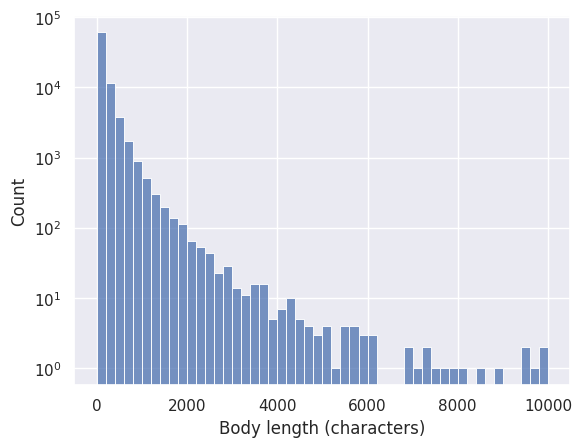

In [50]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths, # lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [51]:
df[lengths >= 10000]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
52507,28645578802,2016-07-25 21:20:49,Thread_crawler,zq5r6,t3_4uk1w1,t3_4uk1w1,1,0,f0nqzwj2hs55zaca0atd3cibzxfs7ee9ltlewgxpfeqn/b...


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

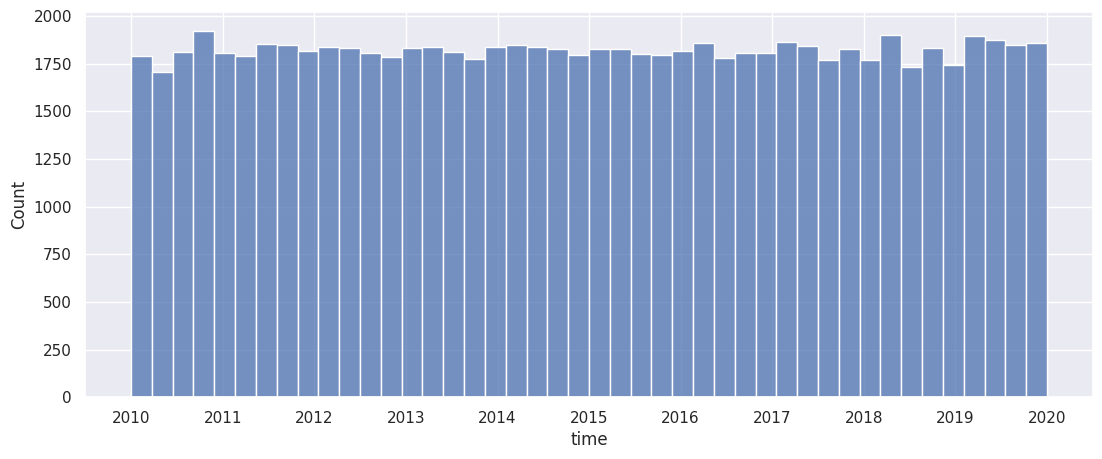

In [52]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
# TODO figure out how to get binwidth to work with timedeltas
sns.histplot(data=df, x=TIME) #, binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

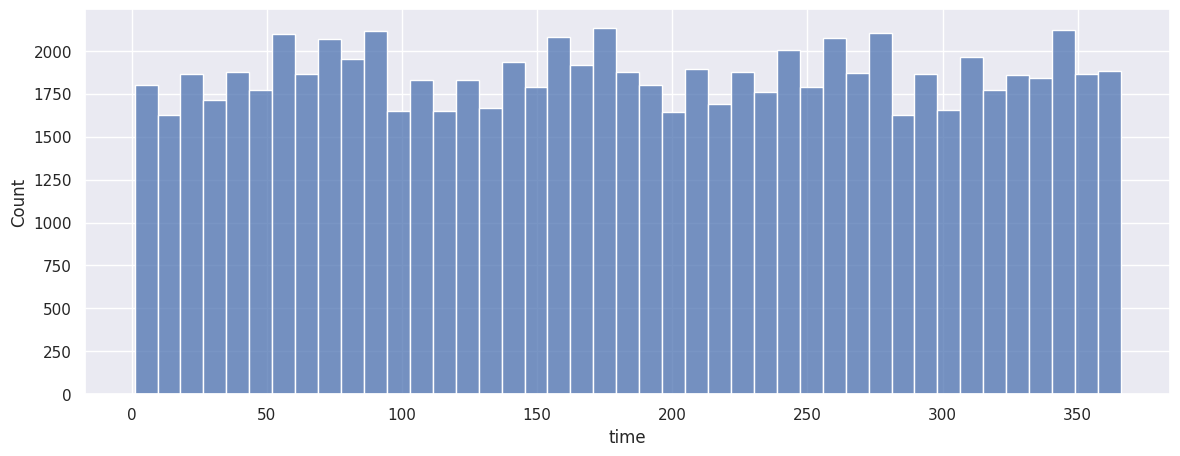

In [53]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

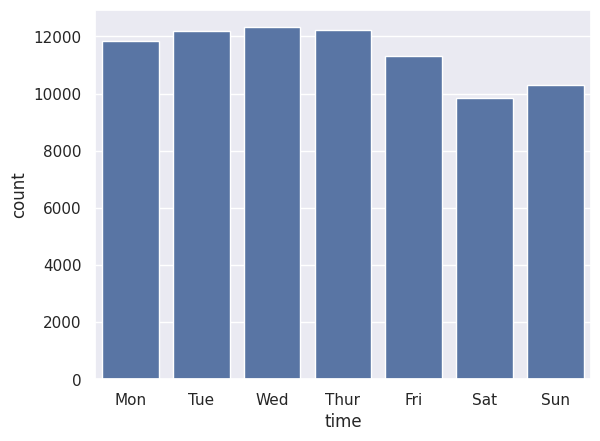

In [54]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

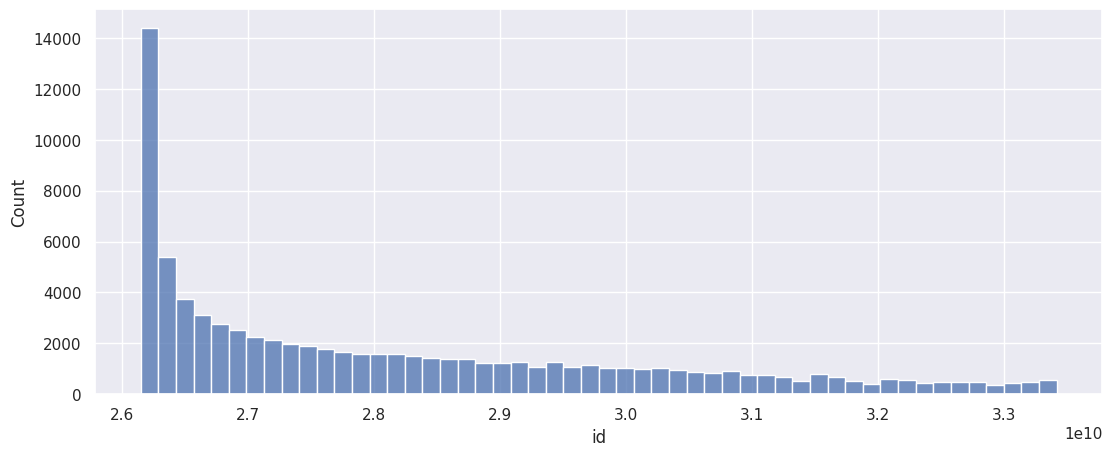

In [55]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [56]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.6421486511132785, pvalue=0.0, statistic_location=0.28395400074727095, statistic_sign=1)

In [57]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151673552,2009-12-31 19:34:47,AskReddit,3qsub,t1_c0i12mx,t3_ake21,1,0,15th


<Axes: >

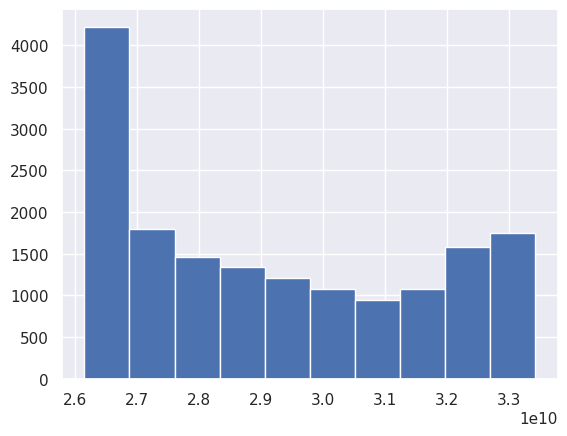

In [58]:
misses.hist()

<Axes: ylabel='Count'>

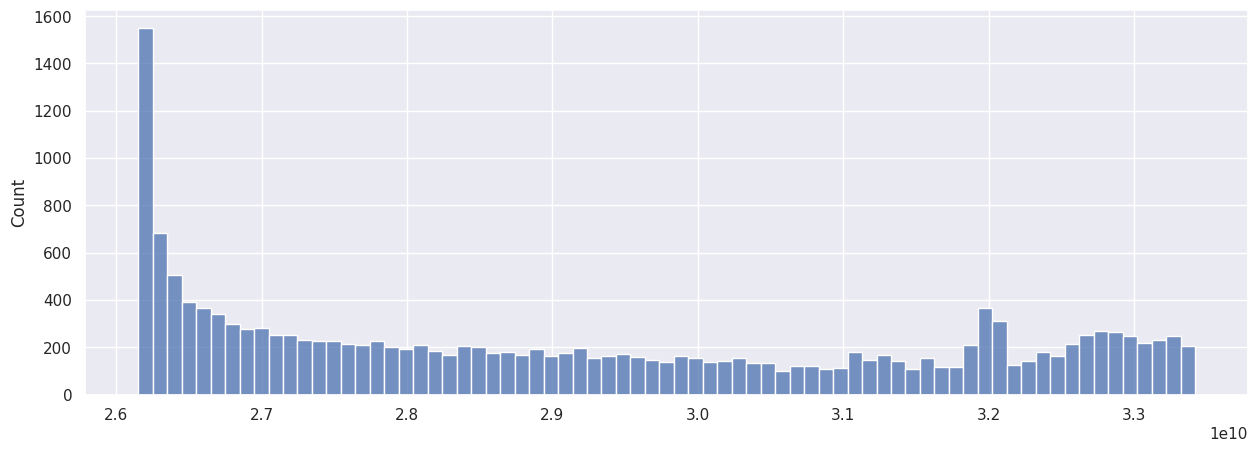

In [59]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

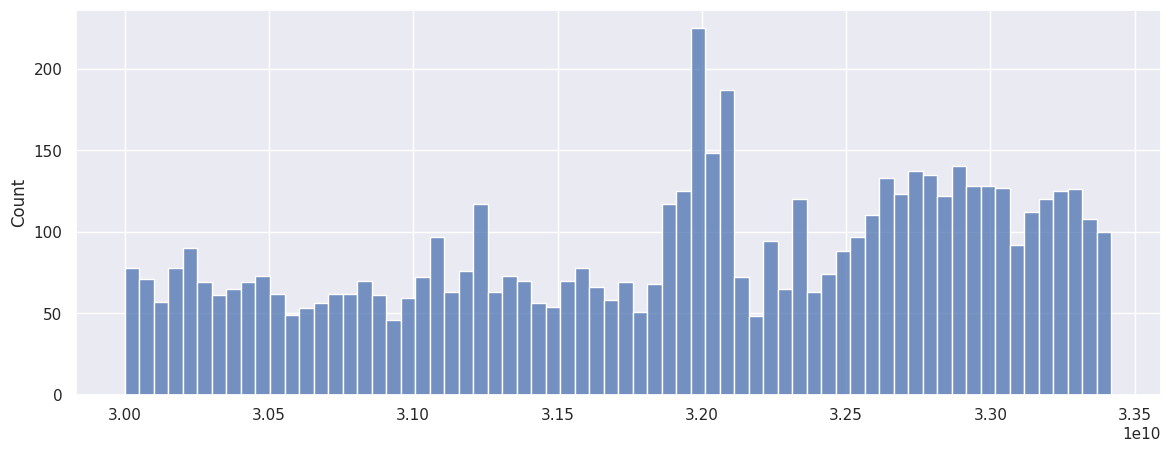

In [60]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [61]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8296062176165803, 0.8296062176165803)

<Axes: xlabel='id', ylabel='rate'>

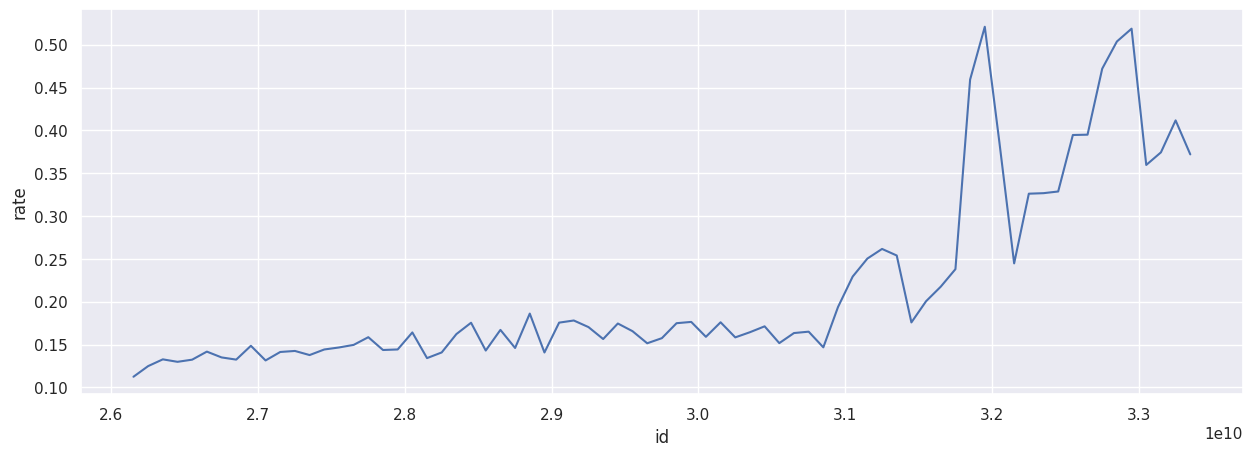

In [62]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [63]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
64056,30000367469,2018-01-03 17:57:15,AskTechnology,dcx10,t3_7nvz9g,t3_7nvz9g,0,0,even 90% relative humidity is perfectly good f...
64057,30000458987,2018-01-03 18:34:00,baseball,12c64x,t1_ds5he8i,t3_7nym1i,1,0,[please](https://www.youtube.com/watch?v=bhoev...
64058,30000498957,2018-01-03 18:50:11,BloomToken,such0,t1_ds5gaz9,t3_7nx70b,3,0,facepalm
64059,30000564883,2018-01-03 19:17:20,goodyearwelt,4udr8,t1_ds5ig08,t3_7nntec,1,0,"no, admittedly i’m basing my opinions largely ..."
64060,30000715666,2018-01-03 20:21:30,FireEmblemHeroes,japq6,t1_ds5nfhv,t3_7nzdvk,8,0,too true. too true.
...,...,...,...,...,...,...,...,...,...
80052,33417439309,2019-12-31 14:09:31,MLjobs,3rw2plx6,t1_fcntyxp,t3_ei6ha7,1,0,considering that there are more than 50 jobs o...
80053,33417567139,2019-12-31 14:34:28,cakeday,2wbnsgxt,t3_ei44s8,t3_ei44s8,1,0,make it work it 2020! (or just keep using redd...
80054,33417843655,2019-12-31 15:24:07,aww,3evapc3o,t1_fcnv7du,t3_ei3fuq,3,0,i was scrolling and looking for this comment. ...
80055,33418099004,2019-12-31 16:17:24,AusFinance,NaN,t3_ei3z8v,t3_ei3z8v,3,0,my folks have one and are pretty happy with it...


In [64]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.10684515363364983, pvalue=6.485856143099705e-164, statistic_location=-0.6747969207202037, statistic_sign=1)

## Subreddits

In [65]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
50,26151871588,2010-01-03 15:30:40,reddit.com,NaN,t1_c0i5cyv,t3_al438,4,0,"no, it's the record where they take into accou..."
86,26152075672,2010-01-05 18:28:04,reddit.com,1f0kz,t1_c0i9pzd,t3_alxuf,3,0,"my dog was pretty tough, i'm thinking he can f..."
107,26152155904,2010-01-06 15:07:54,reddit.com,39c3v,t3_amc7o,t3_amc7o,1,0,"can someone, anyone explain russell brand's se..."
120,26152206094,2010-01-07 02:19:21,reddit.com,359bi,t1_c0icjcp,t3_amkgy,6,0,yessss!
143,26152304024,2010-01-07 23:51:02,reddit.com,3e38s,t3_amzrt,t3_amzrt,8,0,lolwut?
...,...,...,...,...,...,...,...,...,...
14310,26289115215,2011-10-16 01:11:30,reddit.com,5gny7,t1_c2rsh9o,t3_ldjgr,1,0,touché
14314,26289234597,2011-10-16 11:50:47,reddit.com,NaN,t1_c2rxit9,t3_le2pq,3,0,being a close minded retard?\n\nthat's a downv...
14319,26289299626,2011-10-16 15:01:30,reddit.com,61t1s,t1_c2ryh95,t3_le3b7,0,0,"rights are a social contruct. ""natural rights""..."
14336,26289671202,2011-10-17 12:52:35,reddit.com,54xeu,t1_c2s6pgf,t3_lf91m,1,0,not bad


In [66]:
# Most popular subreddits
df[SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit          8126
pics               2227
funny              1778
politics           1646
gaming             1431
WTF                1101
worldnews           893
leagueoflegends     888
reddit.com          850
IAmA                842
videos              813
atheism             801
todayilearned       741
nfl                 728
AdviceAnimals       671
nba                 671
trees               631
soccer              560
news                489
movies              470
Name: count, dtype: int64